In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
import numpy as np
from scipy.stats import multivariate_normal as mvnorm
from scipy.stats import uniform, invgamma, bernoulli, poisson, norm
import statsmodels.api as sm
import pandas as pd
from src.preprocessing import prepare_data, prepare_data_no_standardizing, MAR_data_deletion
from src.model_code import Gibbs_MH
import pymc3 as pm
import arviz as az
from statsmodels.tsa.stattools import acf 
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

In [5]:
df = pd.read_csv('student-mat.csv', sep=",")
features = ["age", "sex", "failures", "higher", "Medu", 
            "absences", "G2", "G3"]
df = df[features]
df.head()

,age,sex,failures,higher,Medu,absences,G2,G3
0,18,F,0,yes,4,6,6,6
1,17,F,0,yes,1,4,5,6
2,15,F,3,yes,1,10,8,10
3,15,F,0,yes,4,2,14,15
4,16,F,0,yes,3,4,10,10


In [6]:
X_df, y_df = prepare_data_no_standardizing(df)
X_df.head()

,age,failures,Medu,absences,G2,sex_M,higher_yes,intercept
0,18,0,4,6,6,0,1,1
1,17,0,1,4,5,0,1,1
2,15,3,1,10,8,0,1,1
3,15,0,4,2,14,0,1,1
4,16,0,3,4,10,0,1,1


In [7]:
X_df_missing = MAR_data_deletion(X_df, 0.05, 0.05, 'higher_yes', 'absences')
X_df_missing

,age,failures,Medu,absences,G2,sex_M,higher_yes,intercept
0,18,0,4,6.0,6,0,1.0,1
1,17,0,1,4.0,5,0,1.0,1
2,15,3,1,10.0,8,0,1.0,1
3,15,0,4,2.0,14,0,1.0,1
4,16,0,3,4.0,10,0,1.0,1
...,...,...,...,...,...,...,...,...
390,20,2,2,11.0,9,1,1.0,1
391,17,0,3,3.0,16,1,1.0,1
392,21,3,1,3.0,8,1,1.0,1
393,18,0,3,0.0,12,1,1.0,1


In [63]:
X = X_df_missing.to_numpy()
y = y_df.to_numpy()
B = 5000
n = len(y)
higher_yes_col = 6
absences_col = 3
age_col = 0
taus = [2.9, 0.9, 0.7, 1]# [3.5, 0.8, 0.7, 1]
thin = 10

In [64]:
(betas, sigmas2, higher_yes_sim, absences_sim, alphas0, alphas1, gammas0, gammas1,
 accepts_alpha0, accepts_alpha1, accepts_gamma0, accepts_gamma1) = Gibbs_MH(X, y, B, n, higher_yes_col, absences_col, age_col, taus, thin)

100%|██████████| 99999/99999 [02:03<00:00, 811.56it/s]


In [65]:
print(accepts_alpha0/(2*B*thin), accepts_alpha1/(2*B*thin), accepts_gamma0/(2*B*thin), accepts_gamma1/(2*B*thin))

0.29204 0.21448 0.53458 0.17604


In [134]:
betas_df = pd.DataFrame(betas.T, columns=[f"beta_{i}" for i in X_df.columns])
higher_yes_df = pd.DataFrame(higher_yes_sim.T, columns=[f"missing_higher_yes_{i}" for i in range(0, higher_yes_sim.shape[0])])
absences_df = pd.DataFrame(absences_sim.T, columns=[f"missing_absences_{i}" for i in range(0, absences_sim.shape[0])])
rest_df = pd.DataFrame({"sigmas2": sigmas2.T,
              "alpha0": alphas0.T,
              "alphas1": alphas1.T,
              "gammas0": gammas0.T, 
              "gammas1": gammas1.T
             })
              
results = pd.concat([betas_df , higher_yes_df, absences_df, rest_df], axis=1) 
results.head()
results.to_csv("results/03results_not_thinned.csv")
              

In [135]:
def MCMC_diagnostics(chain, param):
    plt.subplot(411)
    plt.plot(chain)
    plt.title(f'Trace Plot {param}')

    plt.subplot(412)
    plt.hist(chain, bins=60)
    plt.title(f'Histogram {param}')

    plt.subplot(413)
    gw_plot = pm.geweke(chain)
    plt.scatter(gw_plot[:,0],gw_plot[:,1])
    plt.axhline(-1.98, c='r')
    plt.axhline(1.98, c='r')
    
    plt.ylim(-2.5,2.5)
    plt.title(f'Geweke Plot Comparing first 10% and Slices of the Last 50% of Chain {param}')

    plt.subplot(414)
    acf_values = acf(chain)
    plt.scatter(range(0, len(acf_values)), acf_values)
    plt.title(f'ACF {param}')
    
    plt.tight_layout()
    plt.show()

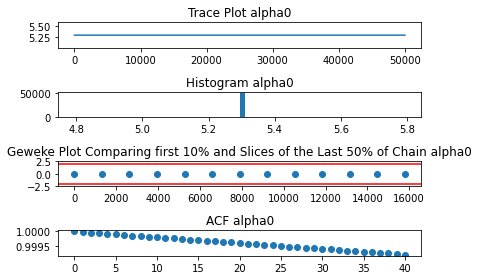

In [136]:
MCMC_diagnostics(alphas0, "alpha0") # need to thin alphas and gammas

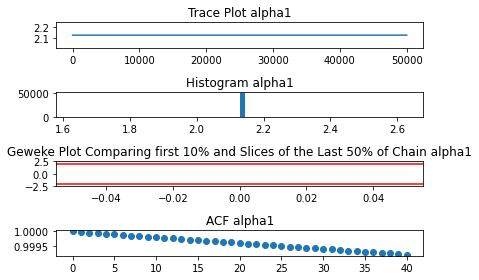

In [137]:
MCMC_diagnostics(alphas1, 'alpha1')

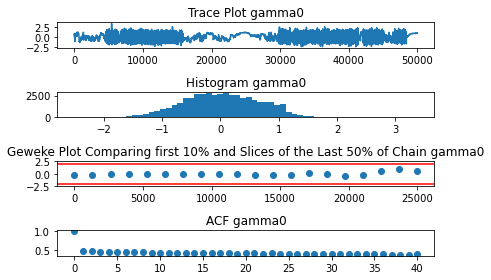

In [138]:
MCMC_diagnostics(gammas0, "gamma0")

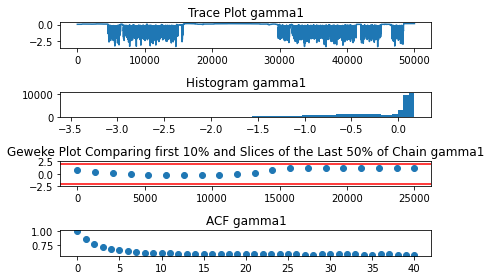

In [139]:
MCMC_diagnostics(gammas1, "gamma1")

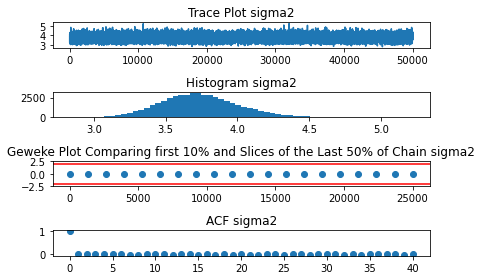

In [140]:
MCMC_diagnostics(sigmas2, "sigma2")

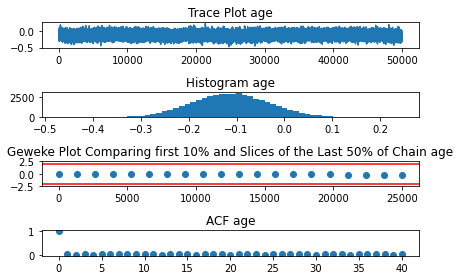

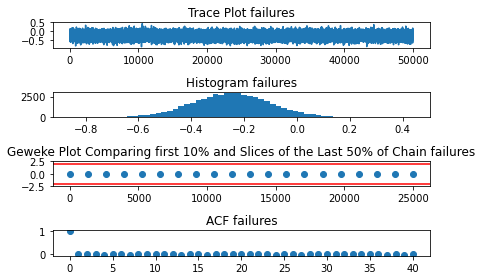

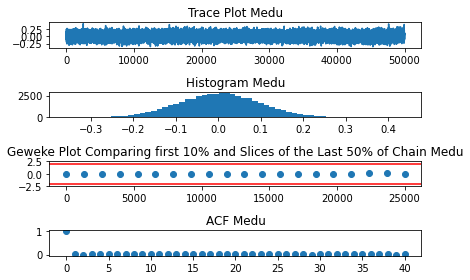

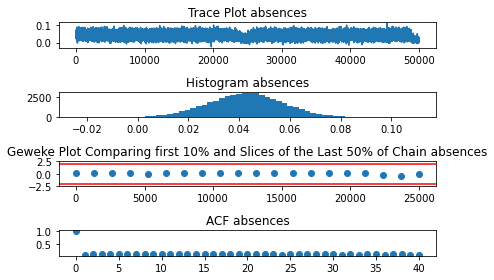

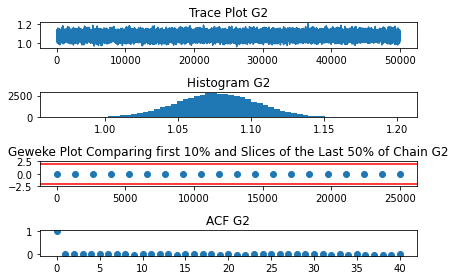

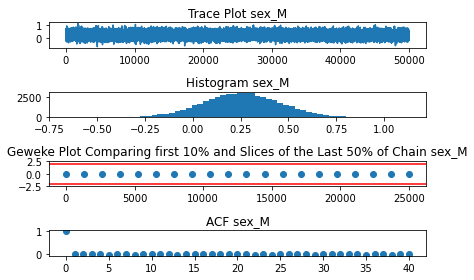

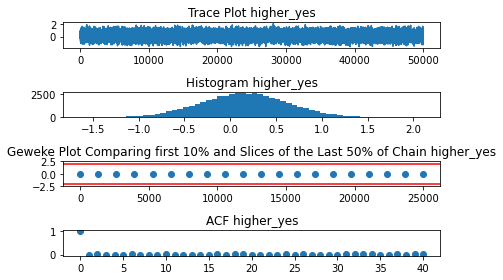

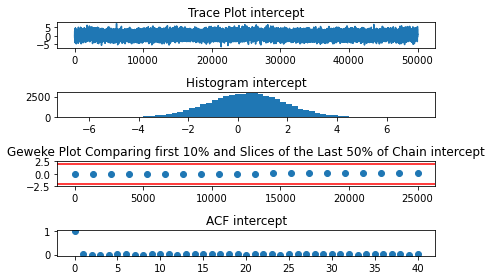

In [141]:
for i, beta in enumerate(betas):
    MCMC_diagnostics(beta, X_df.columns[i])

In [142]:
# thin
betas_thin = betas[:, ::thin]
higher_yes_sim_thin = higher_yes_sim[:, ::thin]
absences_sim_thin = absences_sim[:, ::thin]
alphas0_thin = alphas0[::thin]
alphas1_thin = alphas1[::thin]
gammas0_thin = gammas0[::thin]
gammas1_thin = gammas1[::thin]
sigmas2_thin = sigmas2[::thin]

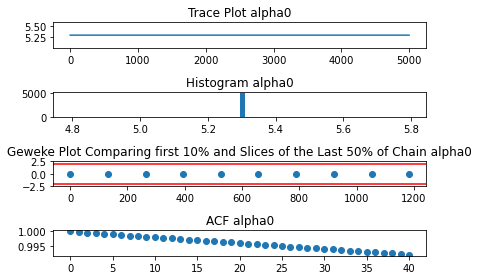

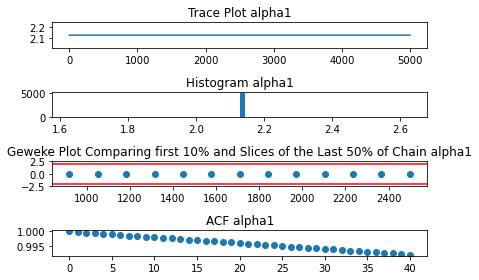

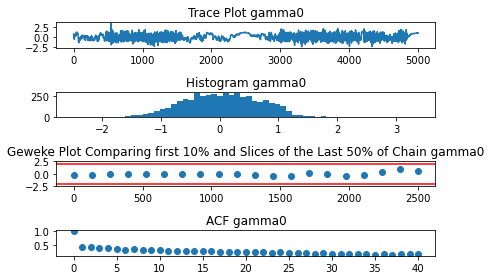

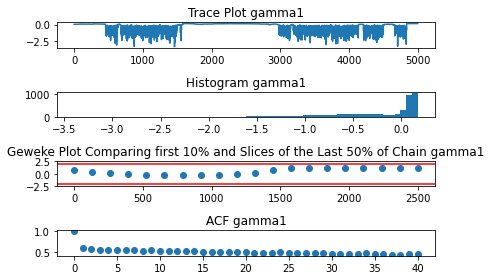

In [143]:
MCMC_diagnostics(alphas0_thin, "alpha0")
MCMC_diagnostics(alphas1_thin, "alpha1")
MCMC_diagnostics(gammas0_thin, "gamma0")
MCMC_diagnostics(gammas1_thin, "gamma1")

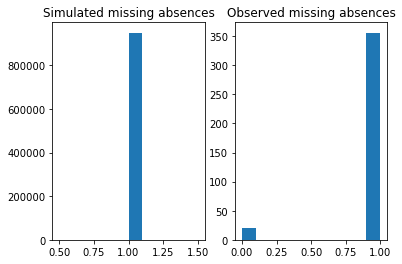

In [155]:
plt.subplot(121)
plt.hist(higher_yes_sim.flatten())
plt.title(f'Simulated missing absences')


plt.subplot(122)
plt.hist(X[:, higher_yes_col])
plt.title(f'Observed absences')

plt.show()

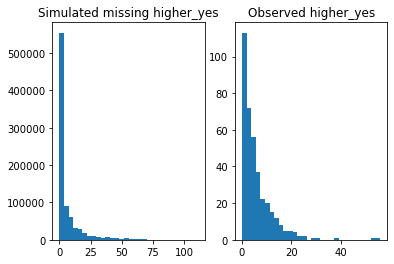

In [157]:
plt.subplot(121)
plt.hist(absences_sim.flatten(), bins=30)
plt.title(f'Simulated missing higher_yes')

plt.subplot(122)
plt.hist(X[:, absences_col], bins=30)
plt.title(f'Observed higher_yes')
plt.show()



In [148]:
betas_df_thinned = pd.DataFrame(betas_thin.T, columns=[f"beta_{i}" for i in X_df.columns])
higher_yes_df_thinned = pd.DataFrame(higher_yes_sim_thin.T, columns=[f"missing_higher_yes_{i}" for i in range(0, higher_yes_sim.shape[0])])
absences_df_thinned = pd.DataFrame(absences_sim_thin.T, columns=[f"missing_absences_{i}" for i in range(0, absences_sim.shape[0])])
rest_df_thinned = pd.DataFrame({"sigmas2": sigmas2_thin.T,
              "alpha0": alphas0_thin.T,
              "alphas1": alphas1_thin.T,
              "gammas0": gammas0_thin.T, 
              "gammas1": gammas1_thin.T
             })
              
results_thinned = pd.concat([betas_df_thinned, higher_yes_df_thinned, absences_df_thinned, rest_df_thinned], axis=1) 
results_thinned.to_csv("results/03results_thinned.csv")
              